# Worksheet 11

Name:  Jiang Cheng Liu
UID: U77948366

### Topics

- Latent Semantic Analysis

### Latent Semantic Analysis

In this section we will fetch news articles from 3 different categories. We will perform Tfidf vectorization on the corpus of documents and use SVD to represent our corpus in the feature space of topics that we've uncovered from SVD. We will attempt to cluster the documents into 3 clusters as we vary the number of singular vectors we use to represent the corpus, and compare the output to the clustering created by the news article categories. Do we end up with a better clustering the more singular vectors we use?

In [12]:
import nltk
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/johnliu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnliu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

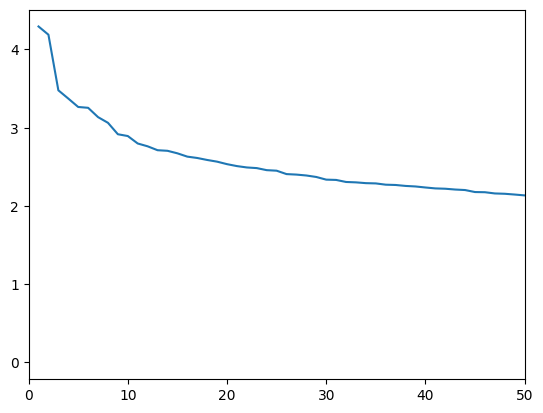

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


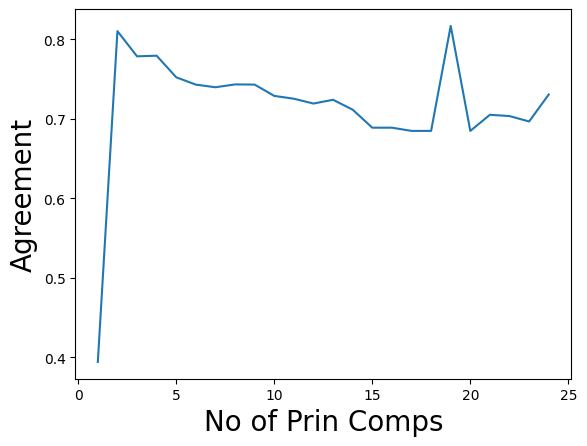

In [14]:

import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

categories = ['comp.os.ms-windows.misc', 'sci.space','rec.sport.baseball']
news_data = fetch_20newsgroups(subset='train', categories=categories)
vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)

stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
         for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in news_data.data]

dtm = vectorizer.fit_transform(stemmed_data)
terms = vectorizer.get_feature_names_out()
centered_dtm = dtm - np.mean(dtm, axis=0)

u, s, vt = np.linalg.svd(centered_dtm)
plt.xlim([0,50])
plt.plot(range(1,len(s)+1),s)
plt.show()

ag = []
max = len(u)
for k in range(1,25):
    vectorsk = u.dot(np.diag(s))[:,:k]
    kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(np.asarray(vectorsk))
    labelsk = kmeans.labels_
    ag.append(metrics.v_measure_score(labelsk, news_data.target)) # closer to 1 means closer to news categories

plt.plot(range(1,25),ag)
plt.ylabel('Agreement',size=20)
plt.xlabel('No of Prin Comps',size=20)
plt.show()


### Embeddings

The data comes from the [Yelp Dataset](https://www.yelp.com/dataset). Each line is a review that consists of a label (0 for negative reviews and 1 for positive reviews) and a set of words.

```
1 i will never forget this single breakfast experience in mad...
0 the search for decent chinese takeout in madison continues ...
0 sorry but me julio fell way below the standard even for med...
1 so this is the kind of food that will kill you so there s t...
```

In order to transform the set of words into vectors, we will rely on a method of feature engineering called word embeddings (Tfidf is one way to get these embeddings). Rather than simply indicating which words are present, word embeddings represent each word by "embedding" it in a low-dimensional vector space which may carry more information about the semantic meaning of the word. (for example in this space, the words "King" and "Queen" would be close).

`word2vec.txt` contains the `word2vec` embeddings for about 15 thousand words. Not every word in each review is present in the provided `word2vec.txt` file. We can treat these words as being "out of vocabulary" and ignore them.

### Example

Let x_i denote the sentence `“a hot dog is not a sandwich because it is not square”` and let a toy word2vec dictionary be as follows:

```
hot      0.1     0.2     0.3
not      -0.1    0.2     -0.3
sandwich 0.0     -0.2    0.4
square   0.2     -0.1    0.5
```

we would first `trim` the sentence to only contain words in our vocabulary: `"hot not sandwich not square”` then embed x_i into the feature space:

$$ φ2(x_i)) = \frac{1}{5} (word2vec(\text{hot}) + 2 · word2vec(\text{not}) + word2vec(\text{sandwich}) + word2vec(\text{square})) = \left[0.02 \hspace{2mm} 0.06 \hspace{2mm} 0.12 \hspace{2mm}\right]^T $$

a) Implement a function to trim out-of-vocabulary words from the reviews. Your function should return an nd array of the same dimension and dtype as the original loaded dataset.

In [18]:
import csv
import numpy as np

VECTOR_LEN = 300   # Length of word2vec vector
MAX_WORD_LEN = 64  # Max word length in dict.txt and word2vec.txt

def load_tsv_dataset(file):
    """
    Loads raw data and returns a tuple containing the reviews and their ratings.

    Parameters:
        file (str): File path to the dataset tsv file.

    Returns:
        An np.ndarray of shape N. N is the number of data points in the tsv file.
        Each element dataset[i] is a tuple (label, review), where the label is
        an integer (0 or 1) and the review is a string.
    """
    dataset = np.loadtxt(file, delimiter='\t', comments=None, encoding='utf-8',
                         dtype='l,O')
    return dataset


def load_feature_dictionary(file):
    """
    Creates a map of words to vectors using the file that has the word2vec
    embeddings.

    Parameters:
        file (str): File path to the word2vec embedding file.

    Returns:
        A dictionary indexed by words, returning the corresponding word2vec
        embedding np.ndarray.
    """
    word2vec_map = dict()
    with open(file) as f:
        read_file = csv.reader(f, delimiter='\t')
        for row in read_file:
            word, embedding = row[0], row[1:]
            word2vec_map[word] = np.array(embedding, dtype=float)
    return word2vec_map


def trim_reviews(path_to_dataset):
    data = load_tsv_dataset(path_to_dataset)
    word2vec_map = load_feature_dictionary("./data/word2vec.txt")
    trimmed_data = []
    for label, review in data:
        words = review.split()
        trimmed_review = []
        for word in words:
            if word in word2vec_map:
                trimmed_review.append(word2vec_map[word])
        trimmed_data.append((label, trimmed_review))
    return trimmed_data

trim_train = trim_reviews("./data/train_small.tsv")
trim_test = trim_reviews("./data/test_small.tsv")
print(trim_test)

[(0, [array([-0.051,  7.15 , -0.307,  0.932,  5.214,  0.012, -0.697,  2.533,
       -0.728, -1.377, -1.412,  1.215, -3.469,  1.383, -1.211,  3.093,
       -3.711, -1.466, -3.411,  1.979, -0.769, -0.431, -1.049,  1.61 ,
        2.069, -0.476, -4.51 ,  0.944,  2.379,  3.188, -3.196, -2.65 ,
       -1.661, -1.722,  3.58 ,  2.896, -0.456, -0.242,  1.505, -2.679,
       -3.283,  0.346, -4.391,  1.764, -2.945, -3.529,  1.68 ,  0.892,
       -3.427,  0.526,  4.23 ,  2.543,  1.687,  5.103, -0.766,  3.957,
        2.138, -4.672,  1.146,  0.076, -1.263,  0.126, -3.883,  2.705,
        0.241,  1.885,  1.681,  3.436,  3.746,  0.231,  6.162,  0.201,
       -3.386,  0.53 ,  2.923,  1.411, -0.292, -6.041, -0.258, -1.099,
       -0.076, -2.94 , -0.866,  3.072, -1.261, -4.175, -0.367, -0.472,
        5.754,  0.772,  1.845, -0.412, -0.855, -1.631,  1.297,  0.538,
       -2.826,  0.658, -0.587, -3.084,  1.544, -0.543,  1.012, -1.753,
       -0.236, -2.646, -1.955,  1.898,  0.742,  5.644,  3.834, -1.084,
